In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.generation.sampling import MaxPosteriorSampling

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, DistanceEstimator, MAFMOGDensityEstimator, MADEMOGDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler, VarianceSource)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KernelDensity

from torch.utils.data import DataLoader, TensorDataset
from torch.quasirandom import SobolEngine

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from uncertaintylearning.utils import functions, bounds as boundsx
from uncertaintylearning.utils.feature_generator import FeatureGenerator
from uncertaintylearning.utils.density_estimator import FixedSmoothKernelDensityEstimator
from uncertaintylearning.utils.density_picker import CrossValidator
from uncertaintylearning.utils.buffer import Buffer
from uncertaintylearning.utils.smo import init_buffer, optimize, make_feature_generator, one_step_acquisition
from uncertaintylearning.models.mcdropout import MCDropout
from uncertaintylearning.models.ensemble import Ensemble

from copy import deepcopy
from itertools import product
functions

{'sinusoid': <function uncertaintylearning.utils.test_functions.sinusoid(X, noise)>,
 'multi_optima': <function uncertaintylearning.utils.test_functions.multi_optima(X, noise)>,
 'booth': <function uncertaintylearning.utils.test_functions.booth(X, noise)>,
 'levi_n13': <function uncertaintylearning.utils.test_functions.levi_n13(X, noise)>,
 'ackley200': <function uncertaintylearning.utils.test_functions.ackley200(X, noise)>,
 'ackley10': <function uncertaintylearning.utils.test_functions.ackley10(X, noise)>}

In [3]:
fct_name = 'levi_n13'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
def invsoftplus(x, beta=1):
    return 1. / beta * (torch.log((beta * x).exp() - 1))

X = (bounds[1] - bounds[0]) * torch.rand(1000, dim) + bounds[0]
Y = f(X)
# X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
# Y = f(X)

In [4]:
dim

2

## COMPARE WITH MANY SEEDS TO GP

Seed 0, Y_init_max -3.1956629753112793
Seed 0, Y_init_max -5.961488723754883
Seed 0, Y_init_max -1.7971960306167603
Y_init_max -1.7971960306167603


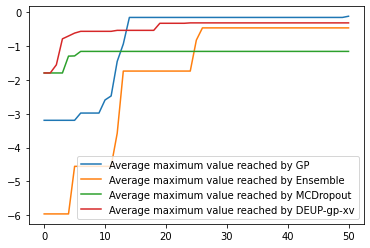

Seed 1, Y_init_max -0.5252314805984497
Seed 1, Y_init_max -4.76159143447876
Seed 1, Y_init_max -11.246380805969238
Y_init_max -11.246380805969238


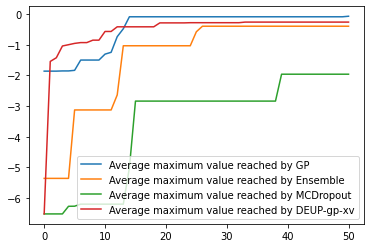

Seed 2, Y_init_max -2.392117977142334
Seed 2, Y_init_max -1.9776278734207153
Seed 2, Y_init_max -3.4362096786499023
Y_init_max -3.4362096786499023


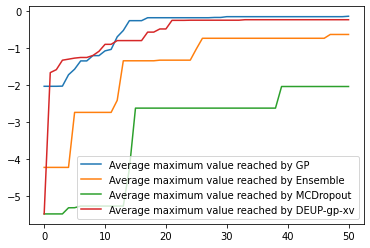

Seed 3, Y_init_max -21.51650619506836
Seed 3, Y_init_max -4.247812747955322
Seed 3, Y_init_max -7.444445610046387


KeyboardInterrupt: 

In [5]:
n_seeds = 5
n_steps = 50
res_gp = np.zeros((n_seeds, 1 + n_steps))

res_ensemble = np.zeros((n_seeds, 1 + n_steps))
res_mcdropout = np.zeros((n_seeds, 1 + n_steps))
    
res_gpdeup = np.zeros((n_seeds, 1 + n_steps))
use_log_unc=True
# res_nndeup = np.zeros((n_seeds, 1 + n_steps))
features = 'xv'

for seed in range(n_seeds):
    torch.manual_seed(10 + seed)
    X_init = (bounds[1] - bounds[0]) * torch.rand(6, dim) + bounds[0]
    Y_init = f(X_init)
    
    print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    outs_gp = optimize(f, bounds, X_init, Y_init, model_type="gp", plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    res_gp[seed] = outs_gp[0]
    
    nets = [create_network(2, 1, 128, 'relu', False, 5, 0.3) for i in range(3)]
    opts = [create_optimizer(nets[i], 1e-4) for i in range(3)]
    ensemble_model = Ensemble(X_init, Y_init, nets, opts, batch_size=64)
    print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    outs_gp = optimize(f, bounds, X_init, Y_init, model_type="ensemble", networks=ensemble_model, plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    res_ensemble[seed] = outs_gp[0]

    network = create_network(2, 1, 128, 'relu', False, 5, 0.3)
    optimizer = create_optimizer(network, 1e-4)
    mcdropout_model = MCDropout(X_init, Y_init, network, optimizer, batch_size=64)
    print(f'Seed {seed}, Y_init_max {Y_init.max().item()}')
    outs_gp = optimize(f, bounds, X_init, Y_init, model_type="mcdropout", networks=mcdropout_model, plot_stuff=False, domain=X, domain_image=Y, n_steps=n_steps)
    res_mcdropout[seed] = outs_gp[0]

    
    
    print(f'Y_init_max {Y_init.max().item()}')
    networks = {
    'e_predictor': create_network(len(features) + (dim - 1 if 'x' in features else 0),
                                  1, 128, 'relu', False if use_log_unc else True, 3),
    'f_predictor': create_network(dim, 1, 128, 'relu', False, 3)
    }
    optimizers = {
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
             }
    outs = optimize(f, bounds, X_init, Y_init, networks=networks, optimizers=optimizers, features=features, plot_stuff=False,
                    n_steps=n_steps, epochs=200, domain=X, domain_image=Y, print_each=100, use_log_unc=True, estimator='gp')
    res_gpdeup[seed] = outs[0]
    
    plt.plot(range(1 + n_steps), res_gp[:seed+1].mean(0),  label='Average maximum value reached by GP')
    plt.plot(range(1 + n_steps), res_ensemble[:seed+1].mean(0),  label='Average maximum value reached by Ensemble')
    plt.plot(range(1 + n_steps), res_mcdropout[:seed+1].mean(0),  label='Average maximum value reached by MCDropout')
    plt.plot(range(1 + n_steps), res_gpdeup[:seed+1].mean(0), label='Average maximum value reached by DEUP-gp-xv')
    # plt.plot(range(1 + n_steps), res_nndeup[:seed+1].mean(0), label='Average maximum value reached by DEUP-nn-xv')
    plt.legend()
    plt.show()


In [ ]:
import pickle
string = """
multi_optima function, 5 seeds, 10..14, xv as features, 6 initial points, log uncertainty prediction, scaled variance on whole domain
"""
pickle.dump({'gp': res_gp, 'gpdeup': res_gpdeup, 'nndeup': res_nndeup, 'info': string}, open('pickles/levi_n13.pkl', 'wb'))

## ACKLEY10

In [ ]:
fct_name = 'ackley10'
use_log_unc=True
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
init_points = 20
n_steps=100
q=10

features='xv'

X_init = (bounds[1] - bounds[0]) * torch.rand(init_points, dim) + bounds[0]
Y_init = f(X_init)

networks = {
    'e_predictor': create_network(len(features) + (dim - 1 if 'x' in features else 0),
                                  1, 128, 'relu', False if use_log_unc else True, 3),
    'f_predictor': create_network(dim, 1, 128, 'relu', False, 3)
    }
optimizers = {
          'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
          'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
         }

    
X_valid = (bounds[1] - bounds[0]) * torch.rand(1000, dim) + bounds[0]
Y_valid = f(X_valid)

optimize(f, bounds, X_init, Y_init, networks=networks, optimizers=optimizers, features=features, plot_stuff=True,
         q=q, n_steps=n_steps, epochs=200, domain=X_valid, domain_image=Y_valid, print_each=1, use_log_unc=True, estimator='nn')